# Import stuff

In [1]:
import pandas as pd
import numpy as np
import spacy
import scipy.sparse as sp
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation, PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.pipeline import TransformerMixin, Pipeline
from string import punctuation
from tqdm import tqdm_notebook
tqdm_notebook().pandas()
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

# Import data, explore and filter

In [2]:
path = "./data/"
df = pd.read_json(path+"news.json", orient="records", lines=True)

In [3]:
df.shape

(200853, 6)

In [4]:
df.dtypes

authors                      object
category                     object
date                 datetime64[ns]
headline                     object
link                         object
short_description            object
dtype: object

In [5]:
df.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


In [6]:
row = df.sample(1)

print("TITLE: ", row.headline.values[0])
      
print("\nDESCRIPTION: ",row.short_description.values[0])

TITLE:  Why Doesn't NASA Just Look for Life?

DESCRIPTION:  The "water found on Mars" story is as perennial as Christmas. NASA doesn't need to tell us that again. So why not cut out the seemingly endless stream of robotic middlemen, and just send hardware that will search for life, big or small? Isn't it time to cut to the chase?


In [7]:
df.category.value_counts(dropna=False)

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

In [8]:
#let's keep only the 10 most represented categories

cat_to_keep = list(df.category.value_counts(dropna=False)[:10].index)
df = df.loc[df.category.isin(cat_to_keep),:]

In [9]:
df.shape

(120008, 6)

# Preprocessing of titles and descriptions
Simple lemmatization and stopwords removal

In [10]:
# load spacy model

nlp = spacy.load("en_core_web_sm", disable=["ner", "tagger", "parser"])

In [11]:
# simple lemmatization with spacy model

def clean_sentence(s):
    
    clean_s = []
    s_prepared = s.lower()
    doc = nlp(s_prepared)
    for tok in doc:
        if tok.lemma_ != "-PRON-":
            clean_s.append(tok.lemma_)
        else:
            clean_s.append(tok.text)
    
    return(clean_s)

In [12]:
df["headline_clean_tok"] = df['headline'].progress_map(clean_sentence)
df["description_clean_tok"] = df['short_description'].progress_map(clean_sentence)

In [13]:
punctuations = set(list(punctuation))
stopwords = STOP_WORDS

stopwords = punctuations.union(stopwords)

In [14]:
# function to remove list of stopwords from list of tokens

def remove_stopwords(tokens, stopwords=stopwords):
    return([token for token in tokens if token not in stopwords])

In [15]:
# let's remove stopwords and convert the lists of tokens to a sentence

df["headline_clean_tok"] = df['headline_clean_tok'].progress_map(remove_stopwords)
df["headline_clean"] = df.headline_clean_tok.progress_map(lambda l: ' '.join(l))

df["description_clean_tok"] = df['description_clean_tok'].progress_map(remove_stopwords)
df["description_clean"] = df.description_clean_tok.progress_map(lambda l: ' '.join(l))

In [16]:
# here is the results of what we have done

row = df.sample(1, random_state=100)

print("TITLE: ", row.headline.values[0])
print("TITLE TOKENIZED: ", row.headline_clean_tok.values[0])
print("TITLE CLEANED: ", row.headline_clean.values[0])

print("\n")

print("DESCRIPTION: ", row.short_description.values[0])
print("DESCRIPTION TOKENIZED: ", row.description_clean_tok.values[0])
print("DESCRIPTION CLEANED: ", row.description_clean.values[0])

TITLE:  The Best Accessories From New York Fashion Week Fall 2014
TITLE TOKENIZED:  ['accessory', 'new', 'york', 'fashion', 'week', 'fall', '2014']
TITLE CLEANED:  accessory new york fashion week fall 2014


DESCRIPTION:  Want more? Be sure to check out HuffPost Style on Twitter, Facebook, Tumblr, Pinterest and Instagram at @HuffPostStyle. All
DESCRIPTION TOKENIZED:  ['want', 'sure', 'check', 'huffpost', 'style', 'twitter', 'facebook', 'tumblr', 'pinterest', 'instagram', '@huffpoststyle']
DESCRIPTION CLEANED:  want sure check huffpost style twitter facebook tumblr pinterest instagram @huffpoststyle


# Create a pipeline using a custom transformer

We want a transformer that performs vectorization of two columns and stacks the results horizontally

In [17]:
# here is our custom transformer

class MultiColumnTfidfVectorizer(TransformerMixin):
    
    def fit(self, X, y=None):
        self.vectorizers = dict()
        for col in X.columns:
            self.vectorizers[col] = TfidfVectorizer().fit(X[col])
        return self
    
    def transform(self, X):
        to_stack = []
        for col in self.vectorizers.keys():
            to_stack.append(self.vectorizers[col].transform(X[col]))
        return(sp.hstack(to_stack))

In [18]:
# create X and y for classification

X = df.loc[:, ["headline_clean", 
               "description_clean"]]

y = df.category.progress_map(lambda s: 1 if s=="POLITICS" else 0)

In [19]:
# split for training and testing

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [20]:
# instanciate pipeline

pipe = Pipeline([("vectorizer", MultiColumnTfidfVectorizer()),
                 ("dim_reduc", TruncatedSVD(n_components=10)),
                 ("clf", RandomForestClassifier(n_estimators=200, verbose=1))
                ])

In [21]:
# fitting pipeline

pipe.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   58.9s finished


Pipeline(memory=None,
     steps=[('vectorizer', <__main__.MultiColumnTfidfVectorizer object at 0x1a308ecba8>), ('dim_reduc', TruncatedSVD(algorithm='randomized', n_components=10, n_iter=5,
       random_state=None, tol=0.0)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_...obs=None,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False))])

In [22]:
# function to plot ROC curve (with AUC)

def plot_roc_auc(y_true, y_prob, title="ROC AUC"):
    auc = roc_auc_score(y_true, y_prob)
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc, color='darkorange')
    plt.plot([0,1], [0,1], color="navy", linestyle='--')
    plt.legend(loc="lower right")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.1s finished


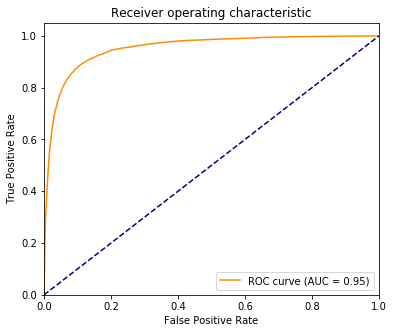

In [23]:
plot_roc_auc(y_test, pipe.predict_proba(X_test)[:, 1])